# Importing Libraries

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Create a Simple Dataset

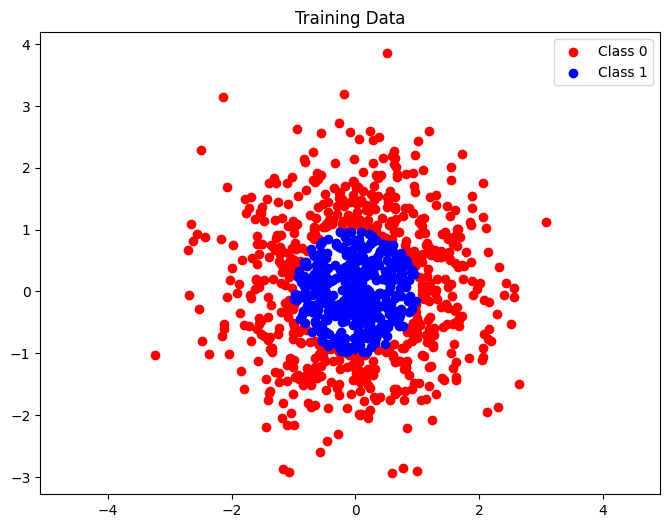

In [51]:
# We'll create a simple binary classification problem
np.random.seed(42)  # For reproducibility

# Generate a circular dataset
def generate_data(n_samples=100):
    X = np.random.randn(n_samples, 2)  # 2D data points
    y = (np.sum(X**2, axis=1) < 1).astype(int)  # 1 if point is inside unit circle, 0 otherwise

    # Convert to one-hot encoding
    y_one_hot = np.zeros((n_samples, 2))
    y_one_hot[np.arange(n_samples), y] = 1

    return X, y_one_hot

X_train, y_train = generate_data(1000)
X_test, y_test = generate_data(200)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train[:, 0] == 1, 0], X_train[y_train[:, 0] == 1, 1], color='red', label='Class 0')
plt.scatter(X_train[y_train[:, 1] == 1, 0], X_train[y_train[:, 1] == 1, 1], color='blue', label='Class 1')
plt.legend()
plt.title('Training Data')
plt.axis('equal')
plt.show()

# Define the Activation Functions

In [52]:
class Activation:
    @staticmethod
    def sigmoid(x):
        """Sigmoid activation function: f(x) = 1 / (1 + e^(-x))"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to avoid overflow

    @staticmethod
    def sigmoid_derivative(x):
        """Derivative of sigmoid: f'(x) = f(x) * (1 - f(x))"""
        s = Activation.sigmoid(x)
        return s * (1 - s)

    @staticmethod
    def relu(x):
        """ReLU activation function: f(x) = max(0, x)"""
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        """Derivative of ReLU: f'(x) = 1 if x > 0 else 0"""
        return np.where(x > 0, 1, 0)

    @staticmethod
    def softmax(x):
        """Softmax activation function: f(x_i) = e^(x_i) / sum(e^(x_j))"""
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max for numerical stability
        return exps / np.sum(exps, axis=1, keepdims=True)

# Define the Loss Function

In [53]:
class Loss:
    @staticmethod
    def cross_entropy(y_true, y_pred):
        """
        Cross-entropy loss function
        y_true: One-hot encoded true labels
        y_pred: Predicted probabilities
        """
        # Adding a small epsilon to avoid log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

    @staticmethod
    def cross_entropy_derivative(y_true, y_pred):
        """
        Derivative of the cross-entropy loss with respect to y_pred
        """
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -y_true / y_pred / y_true.shape[0]

# Create the Neural Network Class

In [54]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        """
        Initialize a neural network with the given layer sizes.

        Parameters:
        layer_sizes: A list of integers, where each integer is the number of neurons in a layer.
                    The first number is the input size, the last is the output size.
        """
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.weights = []
        self.biases = []

        # Initialize weights and biases
        for i in range(1, self.num_layers):
            # He initialization for weights
            w = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * np.sqrt(2. / self.layer_sizes[i-1])
            b = np.zeros((1, self.layer_sizes[i]))

            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        """
        Forward pass through the network.

        Parameters:
        X: Input data, shape (n_samples, input_size)

        Returns:
        activations: List of activations for each layer
        weighted_inputs: List of weighted inputs for each layer
        """
        activations = [X]  # List to store activations
        weighted_inputs = []  # List to store weighted inputs

        # Forward pass through the network
        a = X
        for i in range(self.num_layers - 2):  # For all layers except the output layer
            z = np.dot(a, self.weights[i]) + self.biases[i]  # Weighted input
            weighted_inputs.append(z)

            a = Activation.relu(z)  # ReLU activation for hidden layers
            activations.append(a)

        # Output layer with softmax activation
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        weighted_inputs.append(z)

        a = Activation.softmax(z)
        activations.append(a)

        return activations, weighted_inputs

    def backward(self, X, y, learning_rate=0.01):
        """
        Backward pass through the network (training step).

        Parameters:
        X: Input data, shape (n_samples, input_size)
        y: Target data, shape (n_samples, output_size)
        learning_rate: Learning rate for weight updates

        Returns:
        loss: The loss after this training step
        """
        n_samples = X.shape[0]

        # Forward pass
        activations, weighted_inputs = self.forward(X)
        y_pred = activations[-1]

        # Calculate the loss
        loss = Loss.cross_entropy(y, y_pred)

        # Initialize gradients
        delta = y_pred - y  # Derivative of cross-entropy loss with softmax

        # Backward pass
        for layer in range(self.num_layers - 2, -1, -1):
            # Calculate gradients for weights and biases
            dw = np.dot(activations[layer].T, delta) / n_samples
            db = np.sum(delta, axis=0, keepdims=True) / n_samples

            # Update weights and biases
            self.weights[layer] -= learning_rate * dw
            self.biases[layer] -= learning_rate * db

            # Propagate error to the previous layer (if not the input layer)
            if layer > 0:
                delta = np.dot(delta, self.weights[layer].T) * Activation.relu_derivative(weighted_inputs[layer-1])

        return loss

    def train(self, X, y, epochs=1000, learning_rate=0.01, batch_size=32, verbose=True):
        """
        Train the neural network.

        Parameters:
        X: Training data, shape (n_samples, input_size)
        y: Target data, shape (n_samples, output_size)
        epochs: Number of training epochs
        learning_rate: Learning rate for weight updates
        batch_size: Batch size for mini-batch gradient descent
        verbose: Whether to print training progress

        Returns:
        losses: List of losses at each epoch
        """
        n_samples = X.shape[0]
        losses = []

        for epoch in range(epochs):
            # Shuffle the data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Mini-batch gradient descent
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                loss = self.backward(X_batch, y_batch, learning_rate)

            # Track the loss every epoch
            activations, _ = self.forward(X)
            epoch_loss = Loss.cross_entropy(y, activations[-1])
            losses.append(epoch_loss)

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

        return losses

    def predict(self, X):
        """
        Make predictions with the neural network.

        Parameters:
        X: Input data, shape (n_samples, input_size)

        Returns:
        predictions: Predicted class labels
        """
        activations, _ = self.forward(X)
        return np.argmax(activations[-1], axis=1)

    def evaluate(self, X, y):
        """
        Evaluate the neural network.

        Parameters:
        X: Input data, shape (n_samples, input_size)
        y: Target data, shape (n_samples, output_size)

        Returns:
        accuracy: The accuracy of the model on the given data
        """
        predictions = self.predict(X)
        true_labels = np.argmax(y, axis=1)
        accuracy = np.mean(predictions == true_labels)
        return accuracy

# Train and Evaluate the Network

Epoch 0, Loss: 0.4672
Epoch 100, Loss: 0.0665
Epoch 200, Loss: 0.0492
Epoch 300, Loss: 0.0413
Epoch 400, Loss: 0.0368
Epoch 500, Loss: 0.0325
Epoch 600, Loss: 0.0295
Epoch 700, Loss: 0.0273
Epoch 800, Loss: 0.0256
Epoch 900, Loss: 0.0244


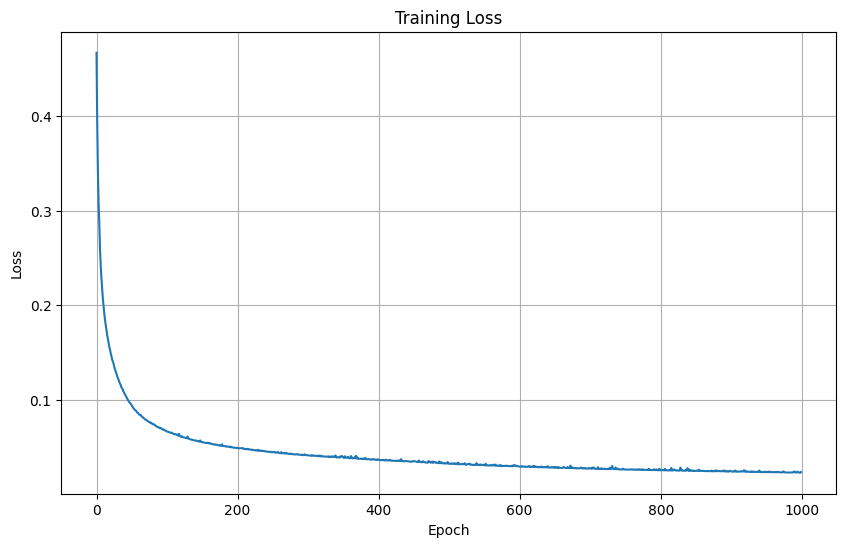

Training Accuracy: 0.9970
Test Accuracy: 0.9900


In [55]:
# Creating a neural network with input size 2, one hidden layer with 16 neurons, and output size 2
nn = NeuralNetwork([2, 16, 2])

# Train the network
losses = nn.train(X_train, y_train, epochs=1000, learning_rate=0.1, verbose=True)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluate the network
train_accuracy = nn.evaluate(X_train, y_train)
test_accuracy = nn.evaluate(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualize the Decision Boundary

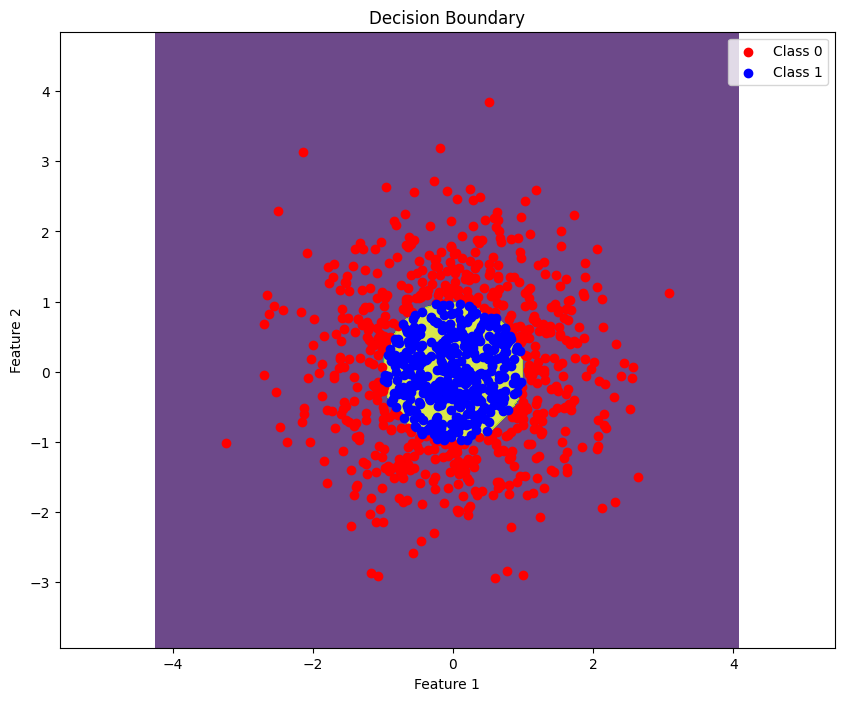

In [56]:
def plot_decision_boundary(model, X, y):
    """Plot the decision boundary of the neural network."""
    h = 0.01  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Make predictions on the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)

    # Plot the training points
    true_labels = np.argmax(y, axis=1)
    plt.scatter(X[true_labels == 0, 0], X[true_labels == 0, 1], color='red', label='Class 0')
    plt.scatter(X[true_labels == 1, 0], X[true_labels == 1, 1], color='blue', label='Class 1')

    plt.legend()
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis('equal')
    plt.show()

# Plot the decision boundary
plot_decision_boundary(nn, X_train, y_train)

# Experiment and Improve

Now that we have a working neural network, we can experiment with different architectures and hyperparameters:

In [57]:
# Experiment with different architectures
architectures = [
    [2, 8, 2],    # Smaller hidden layer
    [2, 32, 2],   # Larger hidden layer
    [2, 16, 16, 2]  # Two hidden layers
]

results = []

for architecture in architectures:
    print(f"Training network with architecture: {architecture}")
    nn = NeuralNetwork(architecture)
    nn.train(X_train, y_train, epochs=1000, learning_rate=0.1, verbose=False)

    train_acc = nn.evaluate(X_train, y_train)
    test_acc = nn.evaluate(X_test, y_test)

    results.append({
        'architecture': architecture,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })

    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}\n")

# Compare the results
for result in results:
    print(f"Architecture: {result['architecture']}")
    print(f"Train Accuracy: {result['train_accuracy']:.4f}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print()

Training network with architecture: [2, 8, 2]
Train Accuracy: 0.9920, Test Accuracy: 0.9800

Training network with architecture: [2, 32, 2]
Train Accuracy: 0.9950, Test Accuracy: 1.0000

Training network with architecture: [2, 16, 16, 2]


<ipython-input-52-960c200e6688>:26: RuntimeWarning: overflow encountered in subtract
  exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max for numerical stability


Train Accuracy: 0.5920, Test Accuracy: 0.5700

Architecture: [2, 8, 2]
Train Accuracy: 0.9920
Test Accuracy: 0.9800

Architecture: [2, 32, 2]
Train Accuracy: 0.9950
Test Accuracy: 1.0000

Architecture: [2, 16, 16, 2]
Train Accuracy: 0.5920
Test Accuracy: 0.5700

